In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50V2, DenseNet201, DenseNet121
from tensorflow.keras.models import Model
import pickle

# Paths and constants
path_datasets = 'D:\Skripsi\program\Data'
path_datasets_splitted = 'D:\Skripsi\program\\Original_Data'
image_height = 224
image_width = 224
batch_size = 1
input_shape = (image_height, image_width, 3)
saved_model_filename = 'Hybrid_CNN_SVM_ResNet50V2_DenseNet201_DenseNet121.sav'

# Image data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

testgen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    os.path.join(path_datasets_splitted, 'Train'),
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = testgen.flow_from_directory(
    os.path.join(path_datasets_splitted, 'Test'),
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

def feature_extraction_models():
    model_a = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
    )

    model_b = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
    )

    model_c = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
    )

    model_a = Model(inputs=model_a.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(model_a.output))
    model_b = Model(inputs=model_b.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(model_b.output))
    model_c = Model(inputs=model_c.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(model_c.output))

    return model_a, model_b, model_c

def combine_features(feature_a, feature_b, feature_c):
        return np.concatenate([feature_a, feature_b, feature_c], axis=1)

def extract_features(generator, models):
    model_a, model_b, model_c = models
    features = []
    labels = []
    for inputs, targets in generator:
        feature_a = model_a.predict(inputs)
        feature_b = model_b.predict(inputs)
        feature_c = model_c.predict(inputs)
        combined_features = combine_features(feature_a, feature_b, feature_c)
        features.append(combined_features)
        labels.append(targets)
        if len(features) >= generator.samples // batch_size:
            break
    return np.vstack(features), np.vstack(labels)

def train_cnn_svm_model(train_generator):
    train_features, train_labels = extract_features(train_generator, feature_extraction_models())
    svm_train_labels = np.argmax(train_labels, axis=1)

    svm_classifier = SVC(
        C=1, 
        kernel='linear', 
        degree=3, gamma='scale', 
        decision_function_shape='ovo'
    )
    svm_classifier.fit(train_features, svm_train_labels)

    with open(saved_model_filename, 'wb') as model_file:
        pickle.dump(svm_classifier, model_file)

    return svm_classifier


def evaluate_cnn_svm_model(test_generator, model):
    # Extract features and labels from the test generator
    test_features, test_labels = extract_features(test_generator, feature_extraction_models())
    
    # Convert one-hot encoded labels to single label per sample
    svm_test_labels = np.argmax(test_labels, axis=1)
    
    # Predict the labels using the SVM model
    test_preds_labels = model.predict(test_features)
    
    # Show normalized confusion matrix
    show_normalized_confusion_matrix(svm_test_labels, test_preds_labels)
    
    # Show confusion matrix with counts
    show_confusion_matrix_counts(svm_test_labels, test_preds_labels)
    
    # Calculate and print the accuracy
    accuracy = accuracy_score(svm_test_labels, test_preds_labels)
    print("Accuracy:", accuracy)
    
    # Print the classification report
    print("Classification Report:")
    print(classification_report(svm_test_labels, test_preds_labels, target_names=["Chickenpox", "Cowpox", "HFMD", "Healthy", "Measles", "Monkeypox"]))


def show_normalized_confusion_matrix(labels, preds):
    # Define custom labels from 0 to 5
    labels_list = ["Chickenpox", "Cowpox", "HFMD", "Healthy", "Measles", "Monkeypox"]
    
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels_list)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    plt.title('Confusion Matrix (Normalized)')
    plt.show()


def show_confusion_matrix_counts(labels, preds):
    # Define custom labels from 0 to 5
    labels_list = ["Chickenpox", "Cowpox", "HFMD", "Healthy", "Measles", "Monkeypox"]
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Display the confusion matrix with counts
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    plt.title('Confusion Matrix (Counts)')
    
    plt.show()



Found 531 images belonging to 6 classes.
Found 224 images belonging to 6 classes.


In [2]:
svm_model = train_cnn_svm_model(train_generator)



1/1 [==============================] - 0s 92ms/step




1/1 [==============================] - 0s 61ms/step


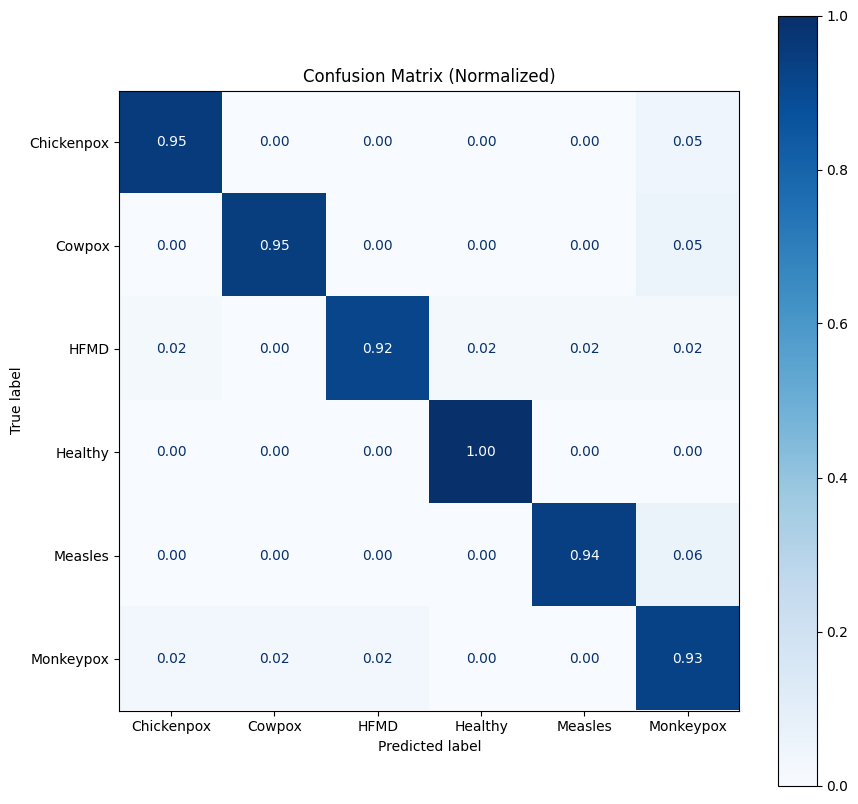

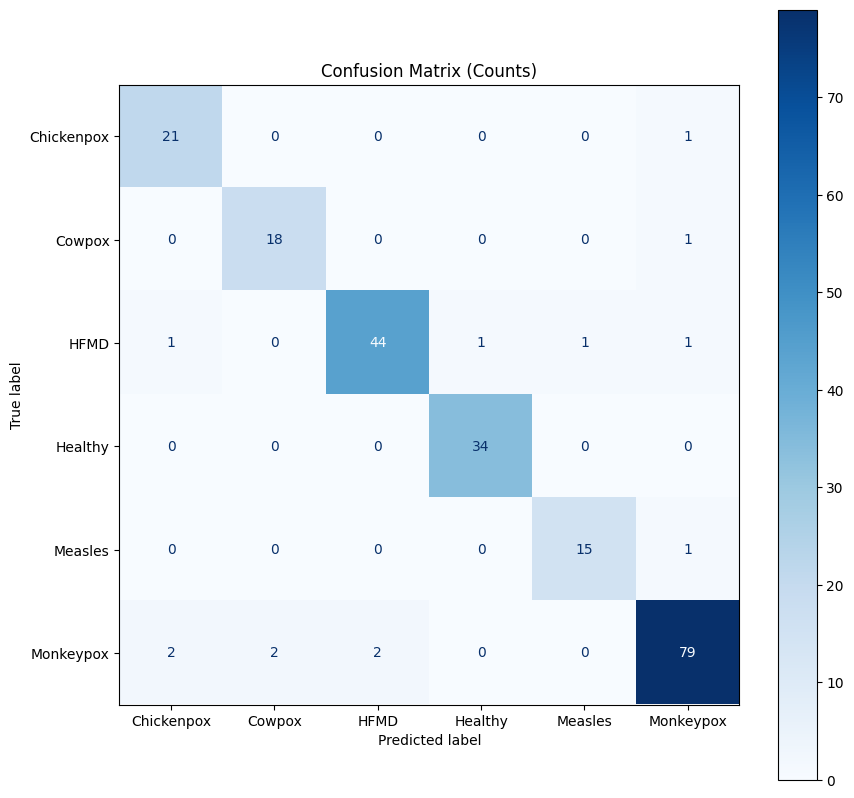

Accuracy: 0.9419642857142857
Classification Report:
              precision    recall  f1-score   support

  Chickenpox       0.88      0.95      0.91        22
      Cowpox       0.90      0.95      0.92        19
        HFMD       0.96      0.92      0.94        48
     Healthy       0.97      1.00      0.99        34
     Measles       0.94      0.94      0.94        16
   Monkeypox       0.95      0.93      0.94        85

    accuracy                           0.94       224
   macro avg       0.93      0.95      0.94       224
weighted avg       0.94      0.94      0.94       224



In [2]:
with open(saved_model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

evaluate_cnn_svm_model(test_generator, loaded_model)